# Importando módulos 

In [69]:
import obspy
import glidertools as gt
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd

#para plotar as figuras
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Lista de Funções 

In [2]:
def dm(x):
    south = False
    
    if x<0:
        south = True
        x = abs(x)
        
    degrees = int(x) // 100
    minutes = x - 100*degrees
    
    x = degrees + minutes/60
    if south:
        x = -x
    return x

In [64]:
def check_datetime_in_period(datetime_lst,dataf):
    '''
    Function to check if the dates in data set are inside the chosen time period
    
    '''
    array_to_plot_by_xlim = []
    for x,c in enumerate(datetime_lst):
        lista_temp = []
        for t,y in enumerate(dataf['DATETIME'].values):
            if y == c.date():
                lista_temp.append(np.array(dataf[dataf['DATETIME'] == y]['NUMBER_HOUR'].tolist()[0]))
        array_to_plot_by_xlim.append(lista_temp)
   
    data_x_axis = []
    for x,c in enumerate(array_to_plot_by_xlim):
        if c != []:
            data_x_axis.append(c[0])
        else:
            data_x_axis.append(np.zeros_like(np.arange(24)))

    data_x_axis = np.array(data_x_axis).T

    return data_x_axis
#----------------------------

# Extraindo informações dos arquivos ".log" e criando um dataframe em PANDAS

In [3]:
os.chdir('/home/diogoloc/dados_posdoc/gliders_project/gliders_data/LOG_data/')

In [4]:
filenames = glob.glob('*/*.log')

In [5]:
filenames[0]

'campanha_02/p6570049.log'

In [43]:
pandas_lst = []
for file in filenames:
    glider_dic = {'file_location':[],'id':[],"campanha":[],'mergulho':[],"time_d_UTC":[],"time_d":[],"time_s":[],"time_s_UTC":[],"lat_s":[],"lon_s":[],"lat_d":[],"lon_d":[],"surface_drift_direction_deg_s":[],"surface_drift_speed_knots_s":[],"surface_drift_direction_deg_d":[],"surface_drift_speed_knots_d":[]}

    with open(file,'r') as f:
        for x in f:
            
            if '$MISSION,' in x:
                glider_dic['file_location'].append(file.split('/')[0])
                glider_dic['campanha'].append(float(x.split('$MISSION,')[1].split('\n')[0]))

            if '$DIVE,' in x:
                glider_dic['mergulho'].append(int(x.split('$DIVE,')[1].split('\n')[0]))
                
            if '$ID,' in x:
                glider_dic['id'].append(int(x.split('$ID,')[1].split('\n')[0]))
    
            if '$GPS2,' in x:
                glider_dic['time_d_UTC'].append(obspy.UTCDateTime(year=int('20'+x.split('$GPS2,')[1].split(',')[0][4:6]), month=int(x.split('$GPS2,')[1].split(',')[0][2:4]), day=int(x.split('$GPS2,')[1].split(',')[0][0:2]),hour=int(x.split('$GPS2,')[1].split(',')[1][0:2]), minute=int(x.split('$GPS2,')[1].split(',')[1][2:4]), second=int(x.split('$GPS2,')[1].split(',')[1][4:6])).datetime)
                glider_dic['time_d'].append(mdates.date2num(obspy.UTCDateTime(year=int('20'+x.split('$GPS2,')[1].split(',')[0][4:6]), month=int(x.split('$GPS2,')[1].split(',')[0][2:4]), day=int(x.split('$GPS2,')[1].split(',')[0][0:2]),hour=int(x.split('$GPS2,')[1].split(',')[1][0:2]), minute=int(x.split('$GPS2,')[1].split(',')[1][2:4]), second=int(x.split('$GPS2,')[1].split(',')[1][4:6])).datetime))
                glider_dic['lat_d'].append(dm(float(x.split('$GPS2,')[1].split(',')[2])))
                glider_dic['lon_d'].append(dm(float(x.split('$GPS2,')[1].split(',')[3])))
                glider_dic['surface_drift_direction_deg_d'].append(float(x.split('$GPS2,')[1].split(',')[-3]))
                glider_dic['surface_drift_speed_knots_d'].append(float(x.split('$GPS2,')[1].split(',')[-4]))         

            if '$GPS,' in x:
                glider_dic['time_s_UTC'].append(obspy.UTCDateTime(year=int('20'+x.split('$GPS,')[1].split(',')[0][4:6]), month=int(x.split('$GPS,')[1].split(',')[0][2:4]), day=int(x.split('$GPS,')[1].split(',')[0][0:2]),hour=int(x.split('$GPS,')[1].split(',')[1][0:2]), minute=int(x.split('$GPS,')[1].split(',')[1][2:4]), second=int(x.split('$GPS,')[1].split(',')[1][4:6])).datetime)
                glider_dic['time_s'].append(mdates.date2num(obspy.UTCDateTime(year=int('20'+x.split('$GPS,')[1].split(',')[0][4:6]), month=int(x.split('$GPS,')[1].split(',')[0][2:4]), day=int(x.split('$GPS,')[1].split(',')[0][0:2]),hour=int(x.split('$GPS,')[1].split(',')[1][0:2]), minute=int(x.split('$GPS,')[1].split(',')[1][2:4]), second=int(x.split('$GPS,')[1].split(',')[1][4:6])).datetime))
                glider_dic['lat_s'].append(dm(float(x.split('$GPS,')[1].split(',')[2])))
                glider_dic['lon_s'].append(dm(float(x.split('$GPS,')[1].split(',')[3])))
                glider_dic['surface_drift_direction_deg_s'].append(float(x.split('$GPS,')[1].split(',')[-3]))
                glider_dic['surface_drift_speed_knots_s'].append(float(x.split('$GPS,')[1].split(',')[-4]))
    if glider_dic['time_s'] != []:
        df = pd.DataFrame.from_dict(glider_dic)
        pandas_lst.append(df)                

In [56]:
df_glider_log = pd.concat(pandas_lst)

In [57]:
df_glider_log = df_glider_log.sort_values(by=['time_d_UTC'])

In [59]:
df_glider_log['n_minutes'] =[i.total_seconds()/60.0 for i in df_glider_log['time_s_UTC'] - df_glider_log['time_d_UTC']]

In [86]:
df_glider_log['hour_day'] = [i.hour for i in df_glider_log['time_d_UTC']]
df_glider_log['minute_day'] = [i.minute for i in df_glider_log['time_d_UTC']]


In [87]:
df_glider_log

,file_location,id,campanha,mergulho,time_d_UTC,time_d,time_s,time_s_UTC,lat_s,lon_s,lat_d,lon_d,surface_drift_direction_deg_s,surface_drift_speed_knots_s,surface_drift_direction_deg_d,surface_drift_speed_knots_d,n_minutes,hour_day,DayMonthYear,minute_day
0,campanha_01,656,1.0,4,2018-07-25 18:39:10,17737.777199,17737.814838,2018-07-25 19:33:22,-23.727283,-42.565133,-23.726177,-42.567505,34.9,0.5,84.4,0.7,54.200000,18,2018-07-25,39
0,campanha_01,656,1.0,5,2018-07-25 19:53:44,17737.828981,17737.866331,2018-07-25 20:47:31,-23.728250,-42.551267,-23.726965,-42.561402,50.6,0.0,127.6,0.4,53.783333,19,2018-07-25,53
0,campanha_01,656,1.0,6,2018-07-25 21:10:12,17737.882083,17737.918646,2018-07-25 22:02:51,-23.729033,-42.537300,-23.727230,-42.547087,26.1,0.9,92.6,0.4,52.650000,21,2018-07-25,10
0,campanha_01,656,1.0,7,2018-07-25 22:23:38,17737.933079,17737.967025,2018-07-25 23:12:31,-23.729367,-42.526600,-23.727278,-42.533113,81.8,0.2,74.3,0.0,48.883333,22,2018-07-25,23
0,campanha_01,656,1.0,8,2018-07-25 23:31:51,17737.980451,17738.029734,2018-07-26 00:42:49,-23.728900,-42.512267,-23.726832,-42.523298,141.6,0.0,101.6,0.0,70.966667,23,2018-07-25,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,campanha_08,657,0.0,122,2019-05-08 16:17:28,18024.678796,18024.920498,2019-05-08 22:05:31,-25.995000,-45.003433,-26.022685,-44.971150,219.6,0.7,256.4,0.0,348.050000,16,2019-05-08,17
0,campanha_08,657,0.0,125,2019-05-08 22:22:45,18024.932465,18025.063484,2019-05-09 01:31:25,-25.973283,-45.021350,-25.997843,-45.006657,204.9,0.0,223.8,0.0,188.666667,22,2019-05-08,22
0,campanha_08,657,0.0,130,2019-05-09 01:39:19,18025.068970,18025.265718,2019-05-09 06:22:38,-25.939050,-45.032633,-25.974467,-45.022242,167.4,0.0,219.7,1.0,283.316667,1,2019-05-09,39
0,campanha_08,657,0.0,131,2019-05-09 06:31:16,18025.271713,18025.585104,2019-05-09 14:02:33,-25.932833,-45.072400,-25.940837,-45.033520,275.0,0.5,48.2,0.6,451.283333,6,2019-05-09,31


In [171]:
df_glider_log['DayMonthYear'] = df_glider_log['time_d_UTC'].dt.strftime("%Y-%m-%d")

day_date_lst = sorted(list(set(df_glider_log['DayMonthYear'].values)))

# creating the array to plot
dataframe_lista = []

for day_date in  tqdm(day_date_lst,total=len(day_date_lst), desc='Calculatig minutes per hour'):
    NUMBER_HOUR = []
    df_day = df_glider_log[df_glider_log['DayMonthYear'] == day_date]
    for g,h in enumerate(np.arange(24)):
        df_hour = df_day[df_day['hour_day'] == h]
        n_minutes_day = df_hour['minute_day'].tolist()
        NUMBER_HOUR.append(len(n_minutes_day))
    
    dataframe_lista.append(pd.DataFrame([date.fromisoformat(day_date),NUMBER_HOUR], index=['DATETIME','NUMBER_HOUR']).T)

df_to_plot = pd.concat(dataframe_lista, ignore_index=True)

Calculatig minutes per hour: 100%|████████████| 285/285 [00:03<00:00, 86.00it/s]


In [172]:
campanha_dic_str = {
    'C01':['12/11/15','19/12/15'],'C02':['08/01/16','02/02/16'],'C06':['17/08/16','15/09/16'],'C07':['16/09/16','15/10/16'],
    'C08':['21/10/16','20/11/16'],'C03':['02/02/16','18/04/16'],'C05':['08/07/16','16/08/16'],'C09':['20/11/16','13/01/17'],
    '20':['10/12/17','20/01/18'],'21':['21/01/18','22/02/18'],'22':['22/02/18','05/04/18'],'23':['10/04/18','17/05/18'],
    '24':['22/05/18','06/07/18'],'25':['06/07/18','22/07/18'],'C10':['14/01/17','16/02/17'],'C11':['17/02/17','24/03/17'],
    '12':['25/03/17','29/04/17'],'C13':['30/04/17','02/05/17'],'C15':['03/06/17','10/07/17'],'C16':['12/07/17','16/08/17'],
    '07':['23/03/19','01/05/19'],'08':['02/05/19','16/06/19'],'09':['29/06/19','31/07/19'],'10':['02/08/19','28/08/19'],
    '11':['04/09/19','10/10/19'],'12':['17/08/17','04/10/17'],'C12':['04/10/17','28/10/17'],'71':['29/10/17','09/12/17'],
    '04':['13/11/18','28/11/18'],'06':['10/02/19','14/03/19'],'01':['23/07/18','28/08/18'],'02':['27/08/18','03/10/18'],
    '03':['02/10/18','14/11/18'],'04':['13/11/18','23/12/18']
                    }

In [173]:
len(campanha_dic_str)

32

In [174]:
sorted(campanha_dic_str.values())

[['02/02/16', '18/04/16'],
 ['02/05/19', '16/06/19'],
 ['02/08/19', '28/08/19'],
 ['02/10/18', '14/11/18'],
 ['03/06/17', '10/07/17'],
 ['04/09/19', '10/10/19'],
 ['04/10/17', '28/10/17'],
 ['06/07/18', '22/07/18'],
 ['08/01/16', '02/02/16'],
 ['08/07/16', '16/08/16'],
 ['10/02/19', '14/03/19'],
 ['10/04/18', '17/05/18'],
 ['10/12/17', '20/01/18'],
 ['12/07/17', '16/08/17'],
 ['12/11/15', '19/12/15'],
 ['13/11/18', '23/12/18'],
 ['14/01/17', '16/02/17'],
 ['16/09/16', '15/10/16'],
 ['17/02/17', '24/03/17'],
 ['17/08/16', '15/09/16'],
 ['17/08/17', '04/10/17'],
 ['20/11/16', '13/01/17'],
 ['21/01/18', '22/02/18'],
 ['21/10/16', '20/11/16'],
 ['22/02/18', '05/04/18'],
 ['22/05/18', '06/07/18'],
 ['23/03/19', '01/05/19'],
 ['23/07/18', '28/08/18'],
 ['27/08/18', '03/10/18'],
 ['29/06/19', '31/07/19'],
 ['29/10/17', '09/12/17'],
 ['30/04/17', '02/05/17']]

In [175]:
len(sorted(campanha_dic_str.values()))

32

In [176]:
campanha_dic_dates = []
for i in campanha_dic_str.values():
    campanha_dic_dates.append(obspy.UTCDateTime(year=int('20'+i[0].split('/')[2]), month=int(i[0].split('/')[1]), day=int(i[0].split('/')[0])).datetime.date())

In [177]:
sorted(campanha_dic_dates)

[datetime.date(2015, 11, 12),
 datetime.date(2016, 1, 8),
 datetime.date(2016, 2, 2),
 datetime.date(2016, 7, 8),
 datetime.date(2016, 8, 17),
 datetime.date(2016, 9, 16),
 datetime.date(2016, 10, 21),
 datetime.date(2016, 11, 20),
 datetime.date(2017, 1, 14),
 datetime.date(2017, 2, 17),
 datetime.date(2017, 4, 30),
 datetime.date(2017, 6, 3),
 datetime.date(2017, 7, 12),
 datetime.date(2017, 8, 17),
 datetime.date(2017, 10, 4),
 datetime.date(2017, 10, 29),
 datetime.date(2017, 12, 10),
 datetime.date(2018, 1, 21),
 datetime.date(2018, 2, 22),
 datetime.date(2018, 4, 10),
 datetime.date(2018, 5, 22),
 datetime.date(2018, 7, 6),
 datetime.date(2018, 7, 23),
 datetime.date(2018, 8, 27),
 datetime.date(2018, 10, 2),
 datetime.date(2018, 11, 13),
 datetime.date(2019, 2, 10),
 datetime.date(2019, 3, 23),
 datetime.date(2019, 5, 2),
 datetime.date(2019, 6, 29),
 datetime.date(2019, 8, 2),
 datetime.date(2019, 9, 4)]

In [178]:
campanha_dic_labels = []
for i in campanha_dic_str.keys():
    campanha_dic_labels.append(i)

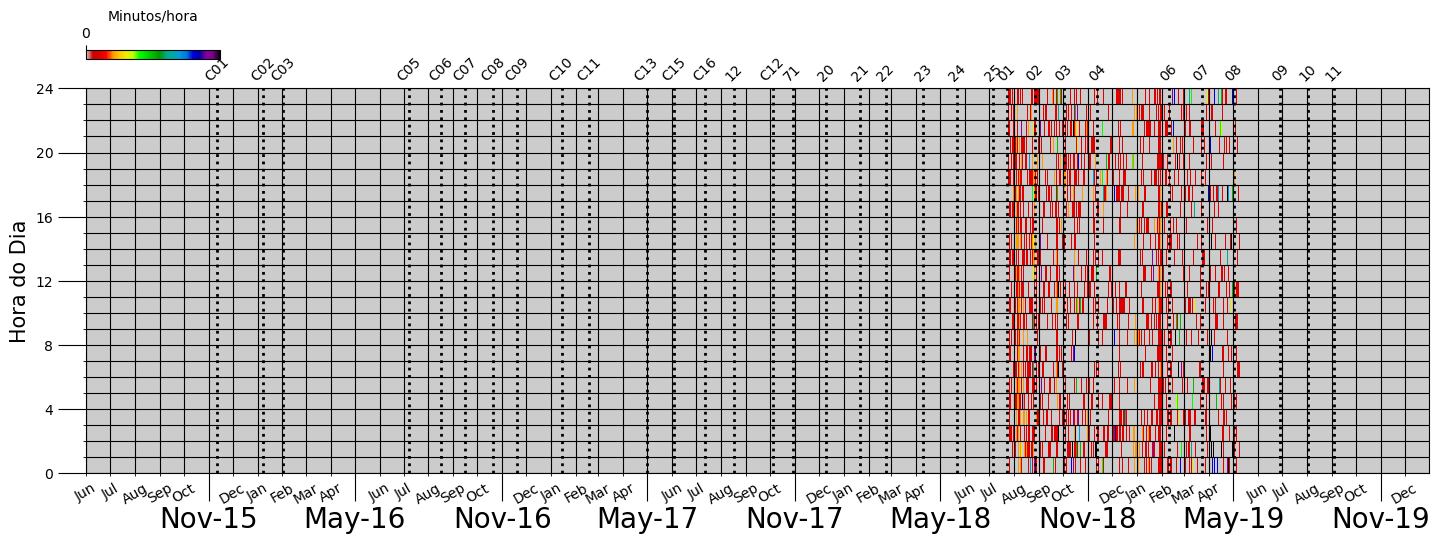

In [179]:
# ==========================================================
# Calculating datetime between INITIAL_DATE and  FINAL_DATE
# ==========================================================

datatime_initial = datetime.strptime('2015-06-01', "%Y-%m-%d").date() 

datatime_final = datetime.strptime('2019-12-31', "%Y-%m-%d").date() 

datetime_lista = np.arange(datatime_initial, datatime_final, timedelta(days=1)).astype(datetime)

xlim_initial = mdates.date2num(datatime_initial)
xlim_final = mdates.date2num(datatime_final)

# ==========================
# Plotting DATA availability
# ==========================
#x axis parameters

months1 = MonthLocator(interval=1)  # every 1 month
months = MonthLocator(interval=6)  # every 6 month
monthsFmt = DateFormatter('%b-%y')
months1Fmt = DateFormatter('%b')

#Matplotlib parameters
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(20,5))

data_x_axis = check_datetime_in_period(datetime_lista,df_to_plot)
datetime_pcolormesh = np.arange(datatime_initial, datatime_final+timedelta(days=1), timedelta(days=1)).astype(datetime)

im = ax.pcolormesh(datetime_pcolormesh,np.arange(25),data_x_axis,cmap='nipy_spectral_r', vmin=0, vmax=10,shading='flat',ec='none')

for dc,date_camp in enumerate(campanha_dic_dates):
    ax.axvline(x = date_camp, color='k', ls=':',lw=2)
    ax.text(date_camp, 24.5, campanha_dic_labels[dc], horizontalalignment='center',rotation=45)
    
ax.set_xlim(datatime_initial,datatime_final)
ax.yaxis.set_major_locator(MultipleLocator(4))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(months1)
ax.xaxis.set_minor_formatter(months1Fmt)
ax.tick_params(which='minor', length=2)
ax.tick_params(which='major', length=20)
ax.set_ylim(0,24)
ax.set_aspect(20.0)
ax.set_ylabel('Hora do Dia',fontsize=15)
ax.grid(visible=True, which='major', color='k', linestyle='-')
ax.grid(visible=True, which='minor', color='k', linestyle='-')

plt.setp(ax.xaxis.get_majorticklabels(), fontsize=20)
plt.setp(ax.xaxis.get_minorticklabels(), fontsize=10,rotation=30)

#criando a localização da barra de cores:
axins = inset_axes(ax,
                    width="10%",  # width = 15% of parent_bbox width
                    height="2.5%",  # height : 2.5%
                    loc='upper left',
                    bbox_to_anchor=(0.0, 0.1, 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0,
                    )
cbar = fig.colorbar(im, cax=axins, orientation="horizontal", ticklocation='top',ticks=[0,20,40,60],label='Minutos/hora')

plt.show()
#os.makedirs(FOLDER_OUTPUT+'/FIGURAS/',exist_ok=True)
#fig.savefig(FOLDER_OUTPUT+'/FIGURAS/'+'COMPLETENESS_'+datatime_initial.strftime("%Y.%m.%d")+datatime_final.strftime("%Y.%m.%d")+'.png',dpi=300)

# Calculando as direções N-S e L-O da deriva em função da velocidade e azimute do glider na superfície

In [33]:
df_glider_log['U_d'] = np.cos(df_glider_log.surface_drift_direction_deg_d) * df_glider_log.surface_drift_speed_knots_d
df_glider_log['V_d'] = np.sin(df_glider_log.surface_drift_direction_deg_d) * df_glider_log.surface_drift_speed_knots_d

df_glider_log['U_s'] = np.cos(df_glider_log.surface_drift_direction_deg_s) * df_glider_log.surface_drift_speed_knots_s
df_glider_log['V_s'] = np.sin(df_glider_log.surface_drift_direction_deg_s) * df_glider_log.surface_drift_speed_knots_s

# Plotando o dataframe em função do tempo

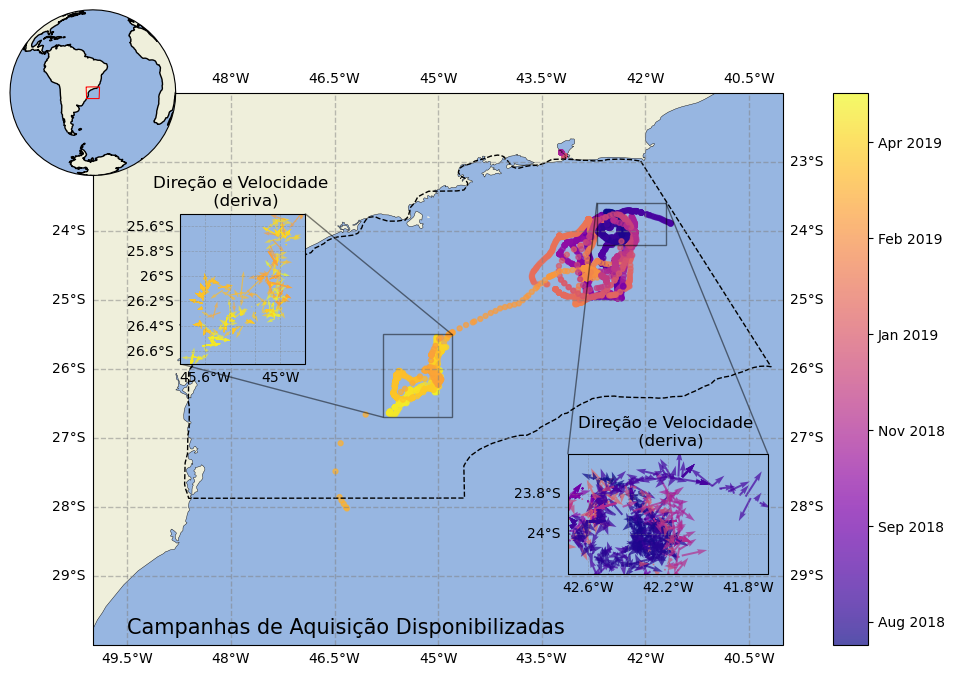

In [34]:
# Create a figure
# set up the plot and create a GeoAxes:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1,figsize=(10,10), subplot_kw=dict(projection=proj))

# ----------------------------------------------------------------------------------------------------------
# Limit the extent of the map to a small longitude/latitude range.
latmin=-30
latmax=-22
lonmin=-50
lonmax=-40

ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

# ----------------------------------------------------------------------------------------------------------
# Adding Title
ax.text(0.05, 0.02, "Campanhas de Aquisição Disponibilizadas", size=15,color='k', transform = ax.transAxes,zorder=10)

# ----------------------------------------------------------------------------------------------------------
# Ploting lat/lon values

#for i in set(df_glider_log['id'].values):
#    if df_glider_log['id']
h = ax.scatter(df_glider_log.lon_d, df_glider_log.lat_d, c=df_glider_log.time_s,marker='.',alpha=0.7,cmap='plasma',s=50,transform=proj)

# ----------------------------------------------------------------------------------------------------------
# Adding background map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)

# ----------------------------------------------------------------------------------------------------------
# Adding grid 
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

# ----------------------------------------------------------------------------------------------------------
# Adding shape file:
ax.add_geometries(shpreader.Reader(filename='/home/diogoloc/dados_posdoc/SIG_Dados/shapes/Bacias Sedimentares/bacia_de_santos.shp').geometries(),crs=ccrs.PlateCarree(),fc='none',ec='k',ls='--')

# ----------------------------------------------------------------------------------------------------------
# Adding inset axes to zoom some features
axins = plt.axes([0.60, 0.25, 0.2, 0.2], projection=proj)

dz = df_glider_log.time_s
norm = colors.Normalize(dz.min(), dz.max())
colors_map = cm.plasma(norm(dz))
axins.set_title("Direção e Velocidade \n (deriva)")
axins.quiver(x=df_glider_log.lon_d,y=df_glider_log.lat_d,u=df_glider_log.U_d,v=df_glider_log.V_d,color=colors_map,pivot='tail',scale=10,width=0.01,alpha=0.7,transform=proj)

axins.add_feature(cfeature.LAND)
axins.add_feature(cfeature.OCEAN)
axins.add_feature(cfeature.COASTLINE,linewidth=0.3)
axins.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
axins.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left"],xlocs=MultipleLocator(0.2),ylocs=MultipleLocator(0.2),linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# subregion of the original image
x1, x2, y1, y2 = -42.7, -41.7, -24.2, -23.6
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])
ax.indicate_inset_zoom(axins, edgecolor="black")

# ----------------------------------------------------------------------------------------------------------
# Adding inset axes to zoom some features
axins2 = plt.axes([0.20, 0.5, 0.15, 0.15], projection=proj)

dz = df_glider_log.time_s
norm = colors.Normalize(dz.min(), dz.max())
colors_map = cm.plasma(norm(dz))
axins2.set_title("Direção e Velocidade \n (deriva)")
axins2.quiver(x=df_glider_log.lon_d,y=df_glider_log.lat_d,u=df_glider_log.U_d,v=df_glider_log.V_d,color=colors_map,pivot='tail',scale=10,width=0.01,alpha=0.7,transform=proj)


axins2.add_feature(cfeature.LAND)
axins2.add_feature(cfeature.OCEAN)
axins2.add_feature(cfeature.COASTLINE,linewidth=0.3)
axins2.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
axins2.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left"],xlocs=MultipleLocator(0.2),ylocs=MultipleLocator(0.2),linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# subregion of the original image
x1, x2, y1, y2 = -45.8, -44.8, -26.7, -25.5
axins2.set_xlim(x1, x2)
axins2.set_ylim(y1, y2)
axins2.set_xticklabels([])
axins2.set_yticklabels([])
ax.indicate_inset_zoom(axins2, edgecolor="black")


# ----------------------------------------------------------------------------------------------------------
# Adding global location map
# inset location relative to main plot (ax) in normalized units
inset_x = 0
inset_y = 1
inset_size = 0.3

# Adding Geoaxes
ax2 = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
ax2.set_global()

# Adding background map 
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)

# Adding inset geoaxes position
ip = InsetPosition(ax, [inset_x - inset_size / 2,
                        inset_y - inset_size / 2,
                        inset_size,
                        inset_size])
ax2.set_axes_locator(ip)


# Adding red rectangle position
nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax2.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='red', linewidth=0.75)

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.5, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb)
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Plotando o dataframe em função da campanha

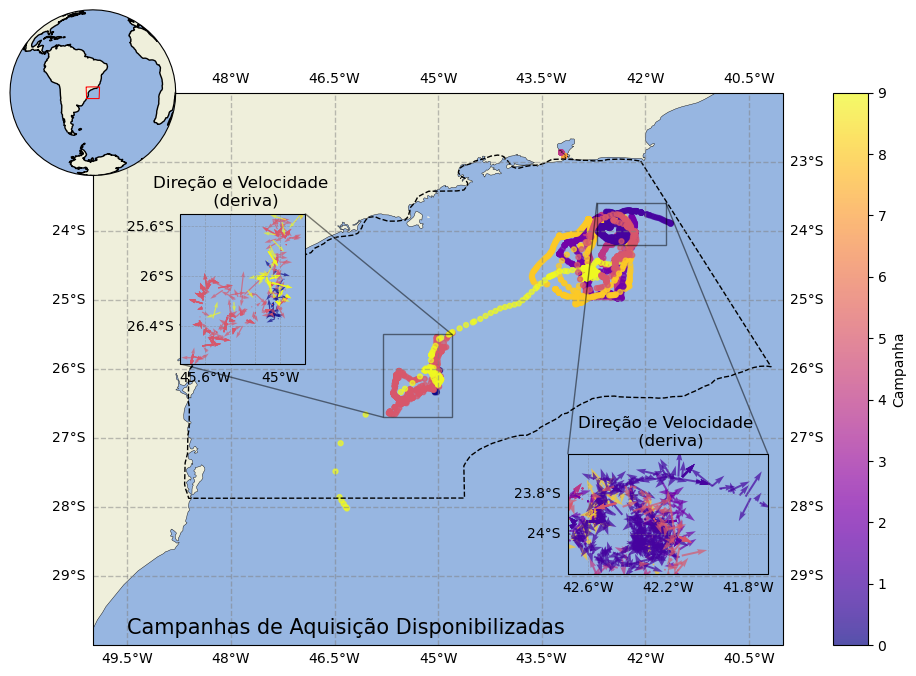

In [35]:
# Create a figure
# set up the plot and create a GeoAxes:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1,figsize=(10,10), subplot_kw=dict(projection=proj))

# ----------------------------------------------------------------------------------------------------------
# Limit the extent of the map to a small longitude/latitude range.
latmin=-30
latmax=-22
lonmin=-50
lonmax=-40

ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

# ----------------------------------------------------------------------------------------------------------
# Adding Title
ax.text(0.05, 0.02, "Campanhas de Aquisição Disponibilizadas", size=15,color='k', transform = ax.transAxes,zorder=10)

# ----------------------------------------------------------------------------------------------------------
# Ploting lat/lon values

#for i in set(df_glider_log['id'].values):
#    if df_glider_log['id']
h = ax.scatter(df_glider_log.lon_d, df_glider_log.lat_d, c=df_glider_log.campanha,marker='.',alpha=0.7,cmap='plasma',s=50,transform=proj)

# ----------------------------------------------------------------------------------------------------------
# Adding background map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)

# ----------------------------------------------------------------------------------------------------------
# Adding grid 
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

# ----------------------------------------------------------------------------------------------------------
# Adding shape file:
ax.add_geometries(shpreader.Reader(filename='/home/diogoloc/dados_posdoc/SIG_Dados/shapes/Bacias Sedimentares/bacia_de_santos.shp').geometries(),crs=ccrs.PlateCarree(),fc='none',ec='k',ls='--')

# ----------------------------------------------------------------------------------------------------------
# Adding inset axes to zoom some features
axins = plt.axes([0.60, 0.25, 0.2, 0.2], projection=proj)

dz = df_glider_log.campanha
norm = colors.Normalize(dz.min(), dz.max())
colors_map = cm.plasma(norm(dz))
axins.set_title("Direção e Velocidade \n (deriva)")
axins.quiver(x=df_glider_log.lon_d,y=df_glider_log.lat_d,u=df_glider_log.U_d,v=df_glider_log.V_d,color=colors_map,pivot='tail',scale=10,width=0.01,alpha=0.7,transform=proj)

axins.add_feature(cfeature.LAND)
axins.add_feature(cfeature.OCEAN)
axins.add_feature(cfeature.COASTLINE,linewidth=0.3)
axins.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
axins.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left"],xlocs=MultipleLocator(0.2),ylocs=MultipleLocator(0.2),linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# subregion of the original image
x1, x2, y1, y2 = -42.7, -41.7, -24.2, -23.6
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])
ax.indicate_inset_zoom(axins, edgecolor="black")

# ----------------------------------------------------------------------------------------------------------
# Adding inset axes to zoom some features
axins2 = plt.axes([0.20, 0.5, 0.15, 0.15], projection=proj)

dz = df_glider_log.campanha
norm = colors.Normalize(dz.min(), dz.max())
colors_map = cm.plasma(norm(dz))
axins2.set_title("Direção e Velocidade \n (deriva)")
axins2.quiver(x=df_glider_log.lon_d,y=df_glider_log.lat_d,u=df_glider_log.U_d,v=df_glider_log.V_d,color=colors_map,pivot='tail',scale=10,width=0.01,alpha=0.7,transform=proj)


axins2.add_feature(cfeature.LAND)
axins2.add_feature(cfeature.OCEAN)
axins2.add_feature(cfeature.COASTLINE,linewidth=0.3)
axins2.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
axins2.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left"],xlocs=MultipleLocator(0.2),ylocs=MultipleLocator(0.4),linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# subregion of the original image
x1, x2, y1, y2 = -45.8, -44.8, -26.7, -25.5
axins2.set_xlim(x1, x2)
axins2.set_ylim(y1, y2)
axins2.set_xticklabels([])
axins2.set_yticklabels([])
ax.indicate_inset_zoom(axins2, edgecolor="black")


# ----------------------------------------------------------------------------------------------------------
# Adding global location map
# inset location relative to main plot (ax) in normalized units
inset_x = 0
inset_y = 1
inset_size = 0.3

# Adding Geoaxes
ax2 = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
ax2.set_global()

# Adding background map 
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)

# Adding inset geoaxes position
ip = InsetPosition(ax, [inset_x - inset_size / 2,
                        inset_y - inset_size / 2,
                        inset_size,
                        inset_size])
ax2.set_axes_locator(ip)


# Adding red rectangle position
nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax2.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='red', linewidth=0.75)

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.5, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h,label='Campanha', cax=ax_cb)

# Plotando o dataframe por campanha:

In [25]:
camp_lst = list(set(df_glider_log['campanha']))

In [26]:
camp_lst

[0.0, 1.0, 2.0, 4.0, 5.0, 7.0, 8.0, 9.0]

Plotando Campanha: 0
Plotando Campanha: 1
Plotando Campanha: 2
Plotando Campanha: 4
Plotando Campanha: 5
Plotando Campanha: 7
Plotando Campanha: 8
Plotando Campanha: 9


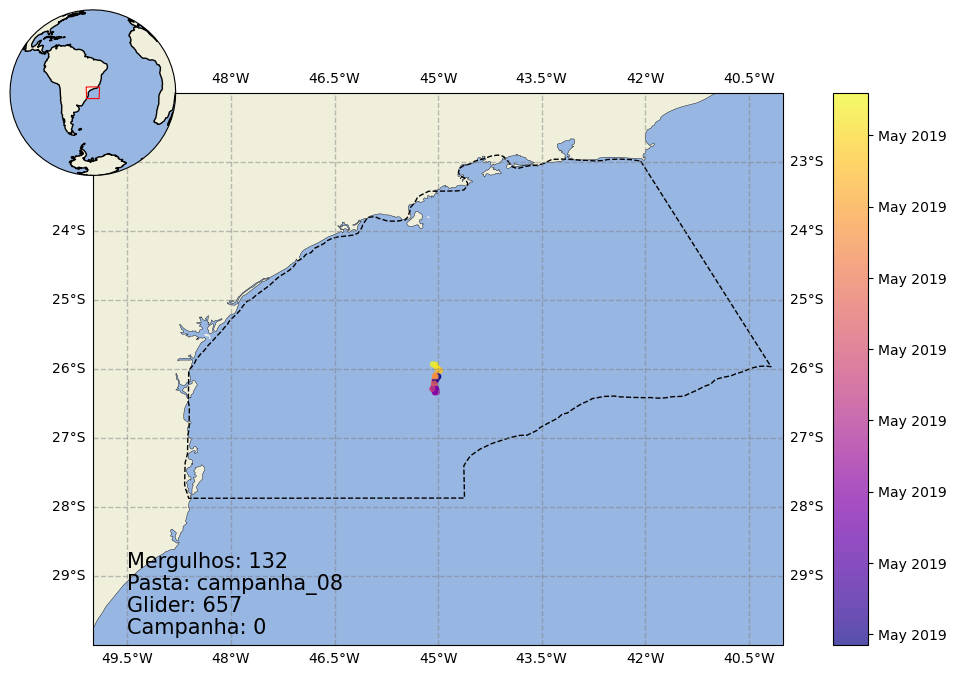

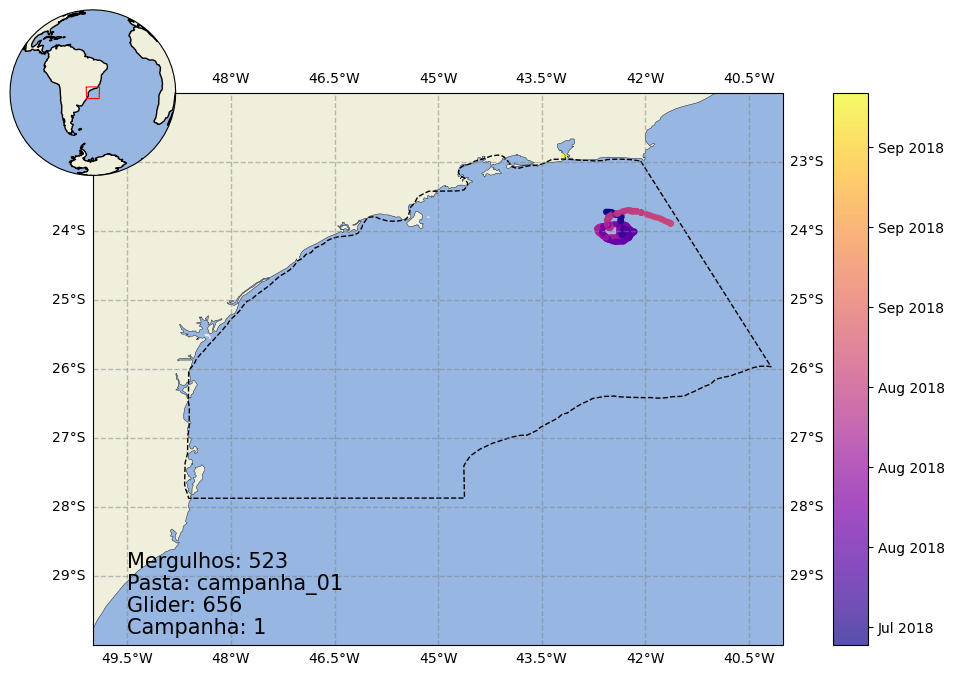

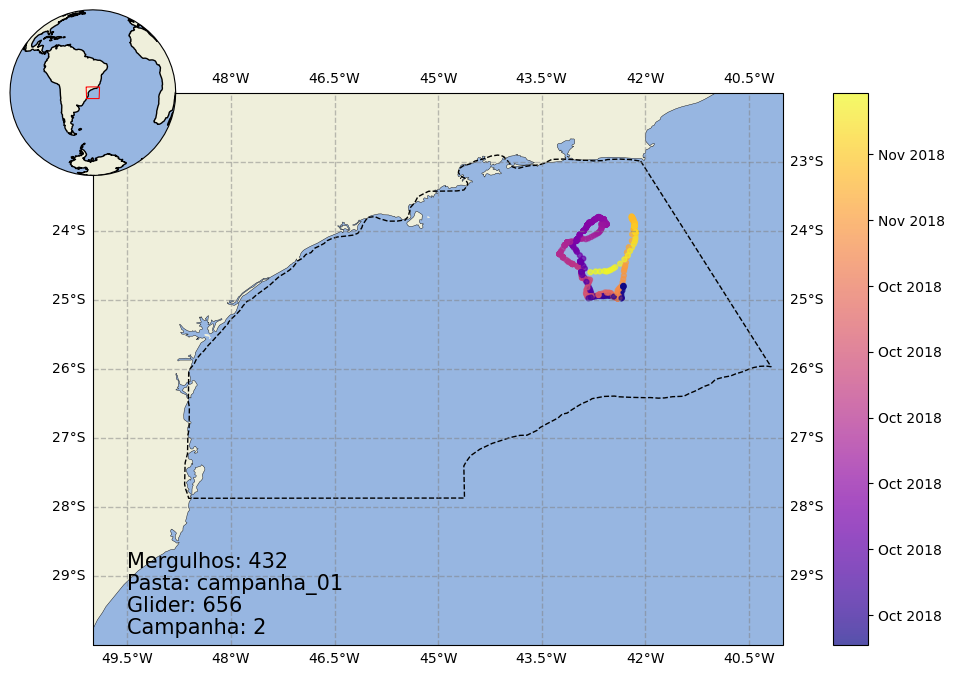

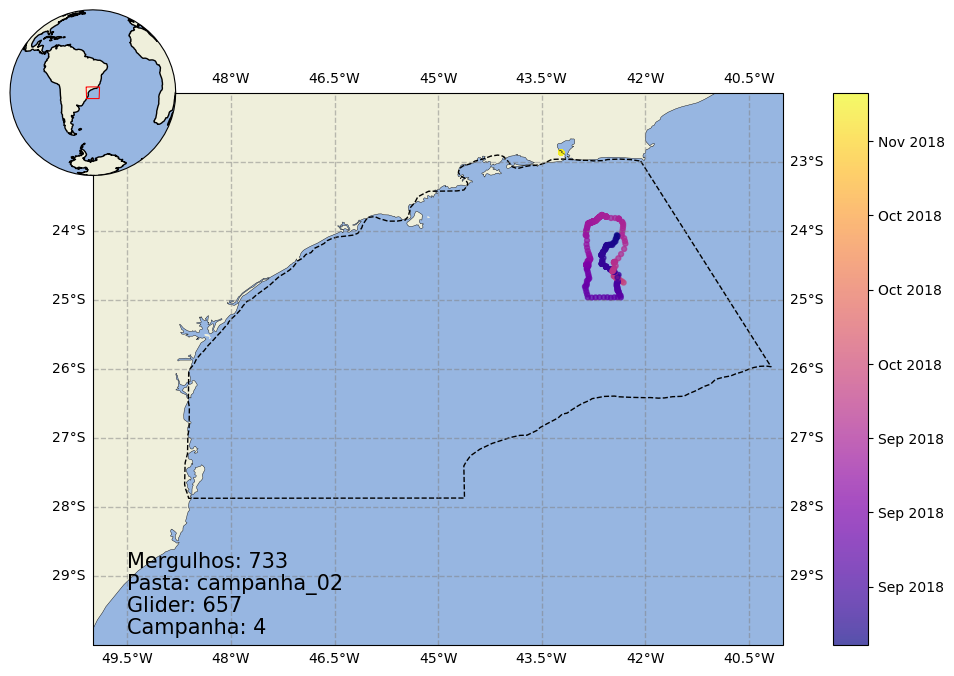

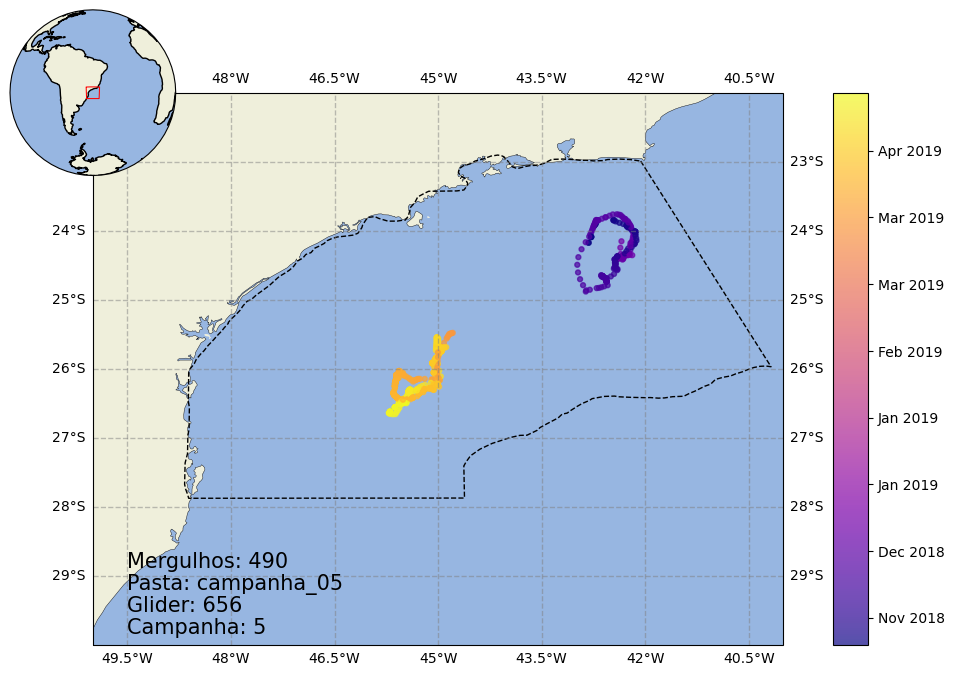

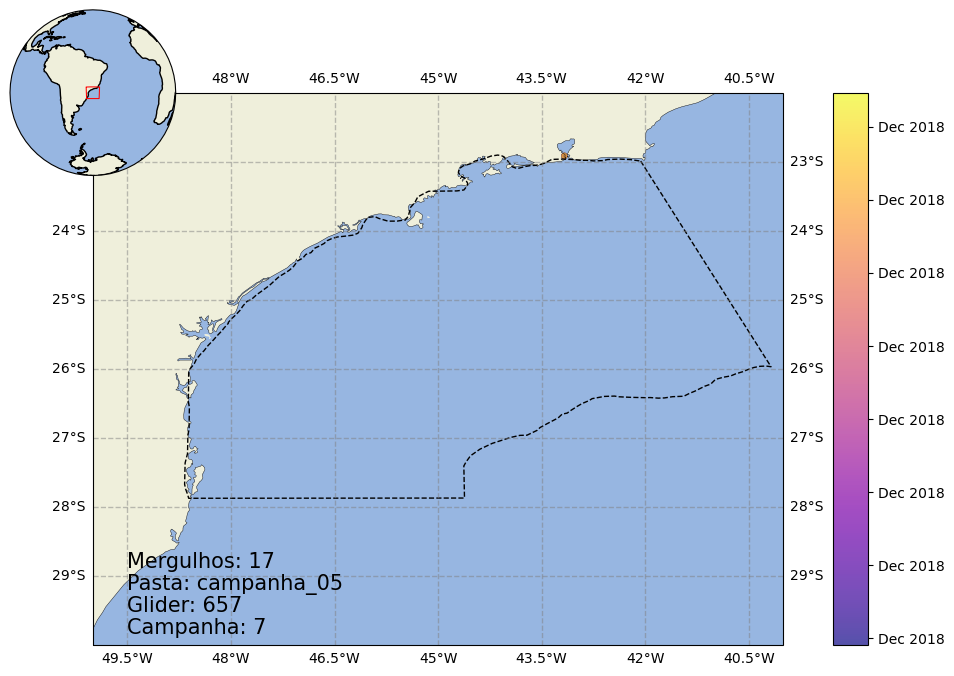

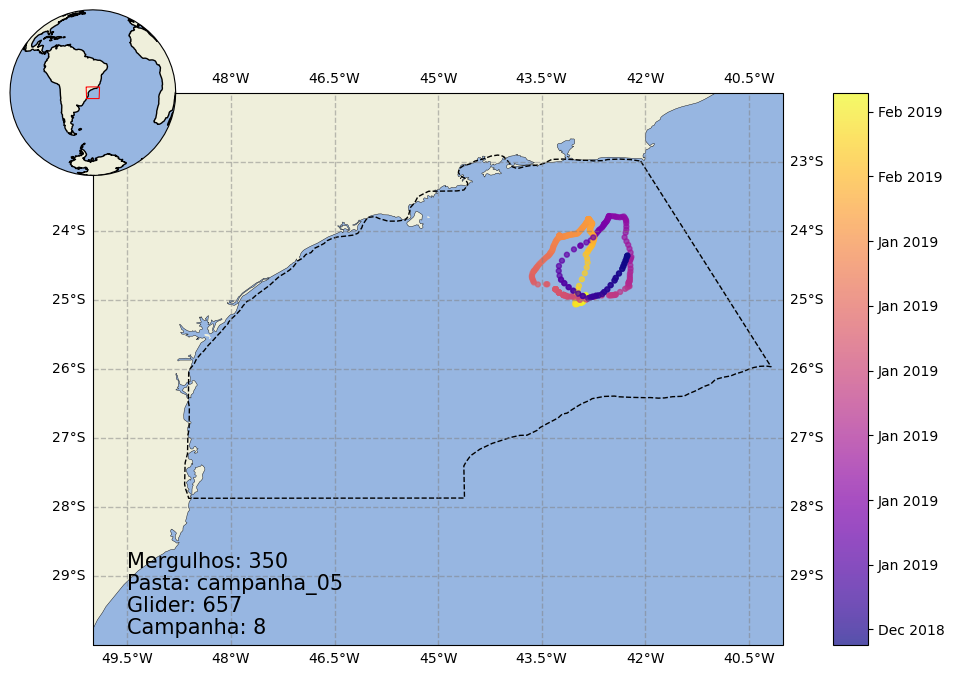

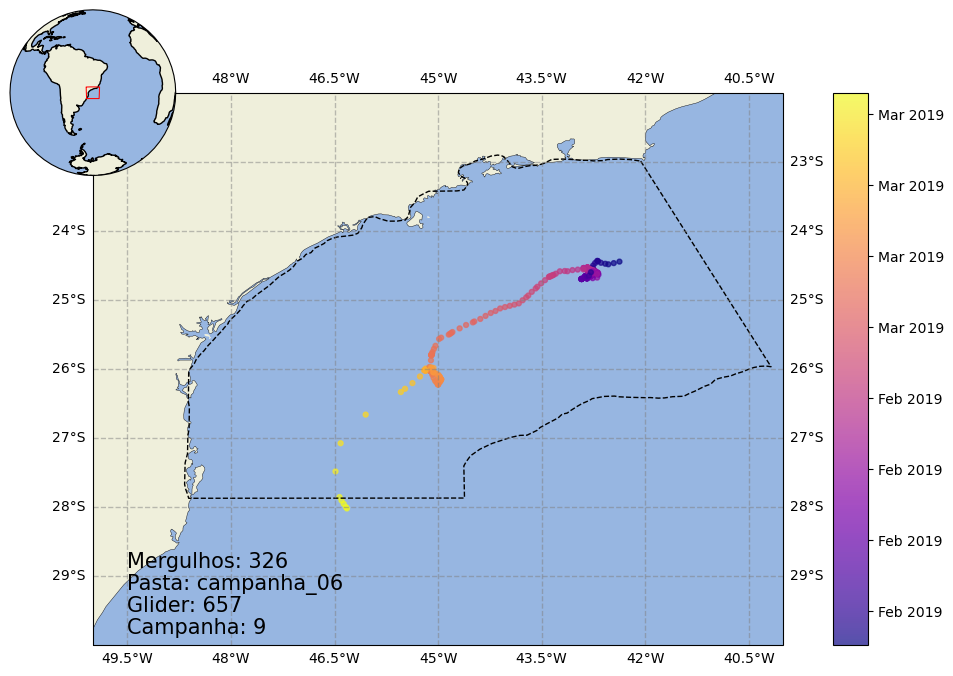

In [40]:
for b,c in enumerate(camp_lst):
    print('Plotando Campanha: '+str(int(c)))
    df_camp =  df_glider_log[df_glider_log['campanha'] == c]
    # Create a figure
    # set up the plot and create a GeoAxes:
    proj = ccrs.PlateCarree()
    fig, ax = plt.subplots(1, 1,figsize=(10,10), subplot_kw=dict(projection=proj))

    # ----------------------------------------------------------------------------------------------------------
    # Limit the extent of the map to a small longitude/latitude range.
    latmin=-30
    latmax=-22
    lonmin=-50
    lonmax=-40

    ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

    # ----------------------------------------------------------------------------------------------------------
    # Adding Title
    ax.text(0.05, 0.14, "Pasta: "+str(list(set(df_camp['file_location']))[0]), size=15,color='k', transform = ax.transAxes,zorder=10)
    ax.text(0.05, 0.10, "Mergulhos: "+str(df_camp['mergulho'].max()), size=15,color='k', transform = ax.transAxes,zorder=10)
    ax.text(0.05, 0.06, "Glider: "+str(list(set(df_camp['id']))[0]), size=15,color='k', transform = ax.transAxes,zorder=10)
    ax.text(0.05, 0.02, "Campanha: "+str(int(c)), size=15,color='k', transform = ax.transAxes,zorder=10)

    # ----------------------------------------------------------------------------------------------------------
    # Ploting lat/lon values

    h = ax.scatter(df_camp.lon_d, df_camp.lat_d, c=df_camp.time_d,marker='.',alpha=0.7,cmap='plasma',s=50,transform=proj)

    # ----------------------------------------------------------------------------------------------------------
    # Adding background map 
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)

    # ----------------------------------------------------------------------------------------------------------
    # Adding grid 
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

    # ----------------------------------------------------------------------------------------------------------
    # Adding shape file:
    ax.add_geometries(shpreader.Reader(filename='/home/diogoloc/dados_posdoc/SIG_Dados/shapes/Bacias Sedimentares/bacia_de_santos.shp').geometries(),crs=ccrs.PlateCarree(),fc='none',ec='k',ls='--')

    # ----------------------------------------------------------------------------------------------------------
    # Adding global location map
    # inset location relative to main plot (ax) in normalized units
    inset_x = 0
    inset_y = 1
    inset_size = 0.3

    # Adding Geoaxes
    ax2 = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
    ax2.set_global()

    # Adding background map 
    ax2.add_feature(cfeature.LAND)
    ax2.add_feature(cfeature.OCEAN)
    ax2.add_feature(cfeature.COASTLINE)

    # Adding inset geoaxes position
    ip = InsetPosition(ax, [inset_x - inset_size / 2,
                            inset_y - inset_size / 2,
                            inset_size,
                            inset_size])
    ax2.set_axes_locator(ip)


    # Adding red rectangle position
    nvert = 100
    lons = np.r_[np.linspace(lonmin, lonmin, nvert),
                 np.linspace(lonmin, lonmax, nvert),
                 np.linspace(lonmax, lonmax, nvert)].tolist()
    lats = np.r_[np.linspace(latmin, latmax, nvert),
                 np.linspace(latmax, latmax, nvert),
                 np.linspace(latmax, latmin, nvert)].tolist()

    ring = LinearRing(list(zip(lons, lats)))
    ax2.add_geometries([ring], ccrs.PlateCarree(),
                       facecolor='none', edgecolor='red', linewidth=0.75)

    # ----------------------------------------------------------------------------------------------------------
    # Adding colorbar
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=0.5, axes_class=plt.Axes)

    fig.add_axes(ax_cb)
    cb = plt.colorbar(h, cax=ax_cb)
    cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))